In [25]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from itertools import product
from stable_baselines3 import A2C
from pathlib import Path
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time
import copy
from tqdm import trange
import os
import pandas as pd
import joblib

In [2]:
path = Path.cwd()
device = 'cpu'

In [3]:

def get_cartpole_values():
    default_values = {}
    values = {}

    default_values['Gravity'] = 9.8
    values['Gravity'] = [0.98, 1.09, 1.23, 1.4, 1.63, 1.96, 2.45, 3.27, 4.9, 19.6, 29.4, 39.2, 49.0, 58.8, 68.6, 78.4, 88.2, 98.0]

    default_values['Mass_cart'] = 1.0
    values['Mass_cart'] = [0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.3333, 0.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

    default_values['Length_pole'] = 0.5
    values['Length_pole'] = [0.05, 0.0556, 0.0625, 0.0714, 0.0833, 0.1, 0.125, 0.1667, 0.25, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

    default_values['Mass_pole'] = 0.1
    values['Mass_pole'] = [0.01, 0.0111, 0.0125, 0.0143, 0.0167, 0.02, 0.025, 0.0333, 0.05, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    default_values['Force_magnitude'] = 10.0
    values['Force_magnitude'] = [1.0, 1.1111, 1.25, 1.4286, 1.6667, 2.0, 2.5, 3.3333, 5.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]

    return default_values, values

def instanciate_cartpole(gravity, mass_cart, length_pole, mass_pole, force_magnitude):
    env = gym.make("CartPole-v1")
    env.gravity = gravity
    env.masscart = mass_cart
    env.masspole = mass_pole
    env.total_mass = env.masspole + env.masscart
    env.length = length_pole  # actually half the pole's length
    env.polemass_length = env.masspole * env.length
    env.force_mag = force_magnitude
    return env

#instanciate_cartpole()
default_values, values = get_cartpole_values()

In [4]:

def get_pendulum_values():
    default_values = {}
    values = {}

    default_values['Gravity'] = 10.0
    values['Gravity'] = [0.5, 1.0, 2.0, 5.0, 20.0, 50.0, 100.0, 200.0]

    default_values['Mass_pole'] = 1.0
    values['Mass_pole'] = [0.05, 0.1, 0.2, 0.5, 2.0, 5.0, 10.0, 20.0]

    default_values['Length_pole'] = 1.0
    values['Length_pole'] = [0.05, 0.1, 0.2, 0.5, 2.0, 5.0, 10.0, 20.0]
    
    default_values['Max_speed'] = 8.0
    values['Max_speed'] = [0.4, 0.8, 1.6, 4.0, 16.0, 40.0, 80.0, 160.0]

    default_values['Max_torque'] = 2.0
    values['Max_torque'] = [0.1, 0.2, 0.4, 1.0, 4.0, 10.0, 20.0, 40.0]

    return default_values, values

def instanciate_pendulum(gravity, mass_pole, length_pole, max_speed, max_torque):
    env = gym.make("Pendulum-v1")
    env.max_speed = max_speed
    env.max_torque = max_torque
    env.g = gravity
    env.m = mass_pole
    env.l = length_pole
    return env

In [5]:
def get_possible_combinaisons(values):
    return [x for x in product(*list(values.values()))]

In [6]:
env = instanciate_cartpole(*list(default_values.values()))

In [7]:
observation = env.reset()
#agent = A2C.load(path/'Agents'/'Pendulum-v1.zip', env=env)

agent = A2C.load(path/'Agents'/'CartPole-v1.zip', env=env)


for _ in range(1000):
    action, _state = agent.predict(observation)
    #env.action_space.sample()
    observation, reward, terminated, info = env.step(action)
    #env.render()

    if terminated:
        observation = env.reset()
env.close()



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/gardille/miniforge3/envs/rl_ood_env/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


In [8]:
def normalize(x, limits):
    """low, high = limits
    norm_x = (x - low)/(high - low)
    norm_x = (norm_x-0.5)*2.0
    assert torch.all(torch.abs(norm_x) <= 1.0)
    return norm_x"""
    return x

def denormalize(x, limits):
    """x = 0.5*x+0.5
    low, high = limits
    return x * (high - low) + low"""
    return x

class MLP(nn.Module):

    def __init__(self, input_size, output_size, size_hidden_layers, bias=True, final_activation=None, dropout=0.1):
        super(MLP, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.size_hidden_layers = size_hidden_layers

        layer = []
        previous_input_size = input_size
        for size_hidden_layer in size_hidden_layers:
            layer.append(nn.Linear(previous_input_size, size_hidden_layer, bias=bias))
            layer.append(nn.ReLU())
            layer.append(torch.nn.Dropout(dropout))
            previous_input_size = size_hidden_layer

        layer.append(nn.Linear(previous_input_size, output_size, bias=False))

        if final_activation is not None:
            layer.append(final_activation)

        

        self.net = nn.Sequential(*layer)

    def forward(self, X):   
        if not torch.is_tensor(X):  
            X = torch.tensor(X)
        X = X.reshape(-1, self.input_size)
        return self.net(X)
    
    

In [9]:
def get_space_limits(space):
    if isinstance(space, gym.spaces.Discrete):
        return np.array([0.0], dtype=np.float32),  np.array([float(env.action_space.n -1)], dtype=np.float32)
    else:
        return space.low, space.high

In [10]:
class Memory(gym.Wrapper):
    def __init__(self, env, size, verbose=False, *args, **kwargs):
        super().__init__(env, *args, **kwargs)
        self.size = size
        self.verbose = verbose
        
        self.obs_limits = get_space_limits(env.observation_space)  
        self.act_limits = get_space_limits(env.action_space)
        
        self.state_size = self.obs_limits[0].shape[0]
        self.action_size = self.act_limits[0].shape[0]
       
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        
        self.history_obs = np.roll(self.history_obs, -self.state_size)
        self.history_obs[-1] = obs
        
        self.history_action = np.roll(self.history_action, -self.action_size)
        self.history_action[-1] = action

        if self.verbose:
            print(self.history_obs)
            print(self.history_action)
        
        return obs, reward, done, info

    def reset(self, *args, **kwargs):
        observation = self.env.reset(*args, **kwargs)
        self.history_obs = np.full((self.size, self.state_size), observation)
        self.history_action = np.full((self.size, self.action_size), 0)
        return observation
        

    def get_history(self, concat=False):
        if concat:
            return np.concatenate((self.history_obs, self.history_action), axis=1)
        else:
            return self.history_obs, self.history_action
    
    


In [11]:
env = instanciate_cartpole(*list(default_values.values()))
mem_env = Memory(env, 5)

In [12]:
mem_env.reset()
mem_env.step(0)
mem_env.get_history(True)

array([[ 0.00808182,  0.04726047, -0.01792521,  0.03433705,  0.        ],
       [ 0.00808182,  0.04726047, -0.01792521,  0.03433705,  0.        ],
       [ 0.00808182,  0.04726047, -0.01792521,  0.03433705,  0.        ],
       [ 0.00808182,  0.04726047, -0.01792521,  0.03433705,  0.        ],
       [ 0.00902703, -0.14759991, -0.01723847,  0.32131094,  0.        ]])

In [13]:
env

<TimeLimit<CartPoleEnv<CartPole-v1>>>

In [14]:
env.reset()

array([-0.03664648, -0.02407401,  0.0085035 , -0.02342753], dtype=float32)

In [27]:


class GaussianModel():
    def __init__(self, env, size_hidden_layers=[1000, 500, 100], size_memory=5, confidence=True, dropout=0.1) -> None:
        self.size_memory = size_memory
        
        self.obs_limits = get_space_limits(env.observation_space)  
        self.act_limits = get_space_limits(env.action_space)
        
        self.state_size = self.obs_limits[0].shape[0]
        self.action_size = self.act_limits[0].shape[0]
        
        input_size, output_size = size_memory*(self.state_size + self.action_size), self.state_size
        
        self.pred_model = MLP(input_size, output_size, size_hidden_layers, bias=True, final_activation=None, dropout=dropout)
        
        self.confidence = confidence
        if self.confidence:
            # nn.LeakyReLU has the advantage to have a symetrical derivative in any point excpet 0.
            # using for example the Softplus function would bias the variance estimation, and be problematic with the test
            self.conf_model = MLP(input_size, output_size, size_hidden_layers, bias=True, final_activation=nn.LeakyReLU(-1.0), dropout=dropout)

        #self.history_size = history_size
        self.criterion = nn.MSELoss()

    def predict_diff_states(self, history):
        X = torch.tensor(history).reshape(self.size_memory*(self.state_size+self.action_size)).float()  

        X.requires_grad = True
        pred_diff = self.pred_model(X) #.detach() 
        
        if self.confidence:
            std = self.conf_model(X) #.detach()
        else:
            std = torch.ones(pred_diff.shape).to(device)
        
        return pred_diff[0], std[0]

    def save(self, folder):
        os.makedirs(folder, exist_ok=True)
        torch.save(self.pred_model.cpu(), folder / 'pred_model.pth')
        if self.confidence:
            torch.save(self.conf_model.cpu(), folder / 'conf_model.pth')
        #joblib.dump(self.scaler_X, folder / 'scaler_X.bin', compress=True)
        #joblib.dump(self.scaler_Y, folder / 'scaler_Y.bin', compress=True)

    def load(self, folder):
        self.pred_model = torch.load(folder / 'pred_model.pth').to(device)
        if self.confidence:
            self.conf_model = torch.load(folder / 'conf_model.pth').to(device)
        #self.scaler_X = joblib.load(folder / 'scaler_X.bin')
        #self.scaler_Y = joblib.load(folder / 'scaler_Y.bin')


    def fit(self, env, nb_steps = 1000, num_epochs=25, lr :float =0.1):
        
        env = Memory(env, self.size_memory)
        models = {'pred':self.pred_model}
        if self.confidence:
            models['conf'] = self.conf_model
  
        for model_type, model in models.items():
            model.train()

            # Observe that all parameters are being optimized
            optimizer = torch.optim.Adam(model.parameters(), lr)

            # Decay LR by a factor of 0.1 every 7 epochs
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            writer = SummaryWriter('tensorboard/model_learning_'+model_type)
            since = time.time()

            best_loss = 1e10

            pbar = trange(num_epochs)
            for epoch in pbar:
                #print(f'Epoch {epoch}/{num_epochs - 1}')
                #print('-' * 10)

                # Each epoch has a training and validation phase
                phase_loss = {}
                    
                observation = env.reset()
                running_loss = 0.0
                
                for t in range(nb_steps):
                    #action, _state = agent.predict(observation)
                    action = env.action_space.sample()
                    previous_obs = observation
                    observation, reward, terminated, info = env.step(action)
                    history = env.get_history(True)
                    
                    observation = torch.FloatTensor(observation).reshape(self.state_size)     
                    #history = torch.FloatTensor(history).reshape(self.size_memory*self.state_size)     
                    #env.render()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(True):
                        #print('inputs: ', inputs.shape)
                        #gap = (observation - previous_obs - pred_diff)/std
                        pred_diff, std = self.predict_diff_states(history)

                        if model_type == 'conf':
                            loss = self.criterion(torch.abs(observation - previous_obs - pred_diff.detach()), std)
                            #loss = self.criterion((outputs - labels)**2, vari)
                        else:
                            loss = self.criterion((observation - previous_obs - pred_diff)/std, torch.zeros(1))

                        loss.backward()
                        optimizer.step()

                        # statistics
                        running_loss += loss.item()
                        
                    if terminated:
                        observation = env.reset()
                        
                    
                scheduler.step()

                epoch_loss = running_loss / nb_steps
                    #print(f'{phase} Loss: {epoch_loss:.4f}')
                    #print()

                    # deep copy the model
                if epoch_loss < best_loss:
                    best_loss = epoch_loss

                writer.add_scalar(model_type+' Loss', epoch_loss, epoch)
                writer.flush()
                
                pbar.set_description("Loss: %2.4f" % (epoch_loss))

            time_elapsed = time.time() - since
            print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            print(f'Best val Loss: {best_loss:4f}')

            
            model.eval()
            
        print()
        return best_loss

    def visualize(self, env, steps=100, saving_path=Path.cwd() / 'Plots', plot=True, figsize=(10, 4), dpi=300):
        env = Memory(env, self.size_memory)
        os.makedirs(saving_path, exist_ok=True)
        writer = SummaryWriter('tensorboard/visualize_model')
        
        self.pred_model = self.pred_model.to(device).eval()
        if self.confidence:
            self.conf_model = self.conf_model.to(device).eval()
        
        observations = []
        actions = []
        pred_diffs = []
        real_diffs = []
        pred_stds = []

        done=True

        if plot:
            pbar = trange(steps)
        else:
            pbar = range(steps)

        observation = torch.FloatTensor(env.reset()).reshape(self.state_size)     
        running_loss = 0.0

        for t in pbar:
            #action, _state = agent.predict(observation)
            action = env.action_space.sample()
            previous_obs = observation
            observation, reward, terminated, info = env.step(action)
            
            history = env.get_history(True)
            
            observation = torch.FloatTensor(observation).reshape(self.state_size)     
            env.render()


            #print('inputs: ', inputs.shape)
            #gap = (observation - previous_obs - pred_diff)/std
            pred_diff, std = self.predict_diff_states(history)
            #pred_diff, std = self.predict_diff_states(previous_obs, action)
            pred_diff, std = pred_diff.detach(), std.detach()


            loss_conf = self.criterion(torch.abs(observation - previous_obs - pred_diff), std)

            loss_pred = self.criterion((observation - previous_obs - pred_diff)/std, torch.zeros(1))

            # statistics
            #running_loss += loss.item()

            if terminated:
                observation = env.reset()

            if plot:
                pbar.set_description("loss_pred: %2.4f, loss_conf: %2.4f" % (loss_pred, loss_conf))



            #print(f'{phase} Loss: {epoch_loss:.4f}')
            #print()
            #writer.add_scalars('run_14h', {'xsinx':np.sin(t), 'xcosx':np.cos(t), 'tanx': np.tan(t)}, t)
            for state_id in range(self.state_size):
                writer.add_scalar('observation/'+str(state_id), np.array(observation)[state_id], t)
                d =  {'predicted': np.array(pred_diff)[state_id], 'real': (np.array(observation) - np.array(previous_obs))[state_id]}

                writer.add_scalars('observation_difference/'+str(state_id),d, t)
                
                writer.add_scalar('observation_std/'+str(state_id), np.array(std)[state_id], t)

            for action_id in range(self.action_size):
                writer.add_scalar('action/'+str(action_id), np.array(action).reshape(self.action_size)[action_id], t)
                
            writer.flush()
            
            observations.append(np.array(observation)) #.numpy()
            actions.append(np.array(action).reshape(self.action_size))
            pred_diffs.append(np.array(pred_diff))
            real_diffs.append(np.array(observation) - np.array(previous_obs))
            pred_stds.append(np.array(std))

            """writer.add_scalar('state/'+str(state_id), distance.numpy(), i)
            writer.add_scalar('state/speed', speed.numpy(), i)
            writer.add_scalar('action', action.numpy(), i)
            writer.add_scalar('diff_distances/prediction', pred_diff_distance.numpy(), i)
            writer.add_scalar('diff_distances/reality', pred_diff_distance.numpy(), i)
            writer.add_scalar('diff_distances/variance', var_distance.numpy(), i)

            writer.add_scalar('diff_speed/prediction', pred_diff_speed.numpy(), i)
            writer.add_scalar('diff_speed/reality', real_diff_speed.numpy(), i)
            writer.add_scalar('diff_speed/variance', var_speed.numpy(), i)
            writer.flush()"""
            
        observations = np.array(observations)
        actions = np.array(actions)
        pred_diffs = np.array(pred_diffs)
        real_diffs = np.array(real_diffs)
        pred_stds = np.array(pred_stds)
        
        for state_id in range(self.state_size):
            

            evolution = {}
            evolution['prediction'] = np.array(pred_diffs[:,state_id])
            evolution['reality'] = np.array(real_diffs[:,state_id])
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of observation component ' + str(state_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_diff_obs', bbox_inches='tight')
                plt.show()

        for action_id in range(self.action_size):
            
            evolution = {}
            evolution['prediction'] = np.array(actions[:,action_id])
            evolution['reality'] = np.array(actions[:,action_id])
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of action component ' + str(action_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_act', bbox_inches='tight')
                plt.show()

        

        """
        error_diff_distances = diff_distance_dict['prediction'] - diff_distance_dict['reality']
        if plot:
            plot_error_variance(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, unit='m')
            plot_error_corrected(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, dpi=dpi)
            plot_error_confidence_from_variance(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, dpi=dpi, unit='m')

        error_diff_speeds = diff_speed_dict['prediction'] - diff_speed_dict['reality']
        if plot:
            plot_error_variance(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, unit='m/s')
            plot_error_corrected(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, dpi=dpi)
            plot_error_confidence_from_variance(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, dpi=dpi, unit='m/s')
        """
        return observations, actions, pred_diffs, real_diffs, pred_stds


In [28]:
model = GaussianModel(env, confidence=False, dropout=0.0)
model.fit(env, nb_steps=1000, lr=0.001)
model.save(path / 'saved_models' / 'no_confidence')

Loss: 0.0000: 100%|█████████████████████████████| 25/25 [00:44<00:00,  1.78s/it]

Training complete in 0m 44s
Best val Loss: 0.000001



loss_pred: 0.0000, loss_conf: 0.9982: 100%|███| 100/100 [00:01<00:00, 56.42it/s]


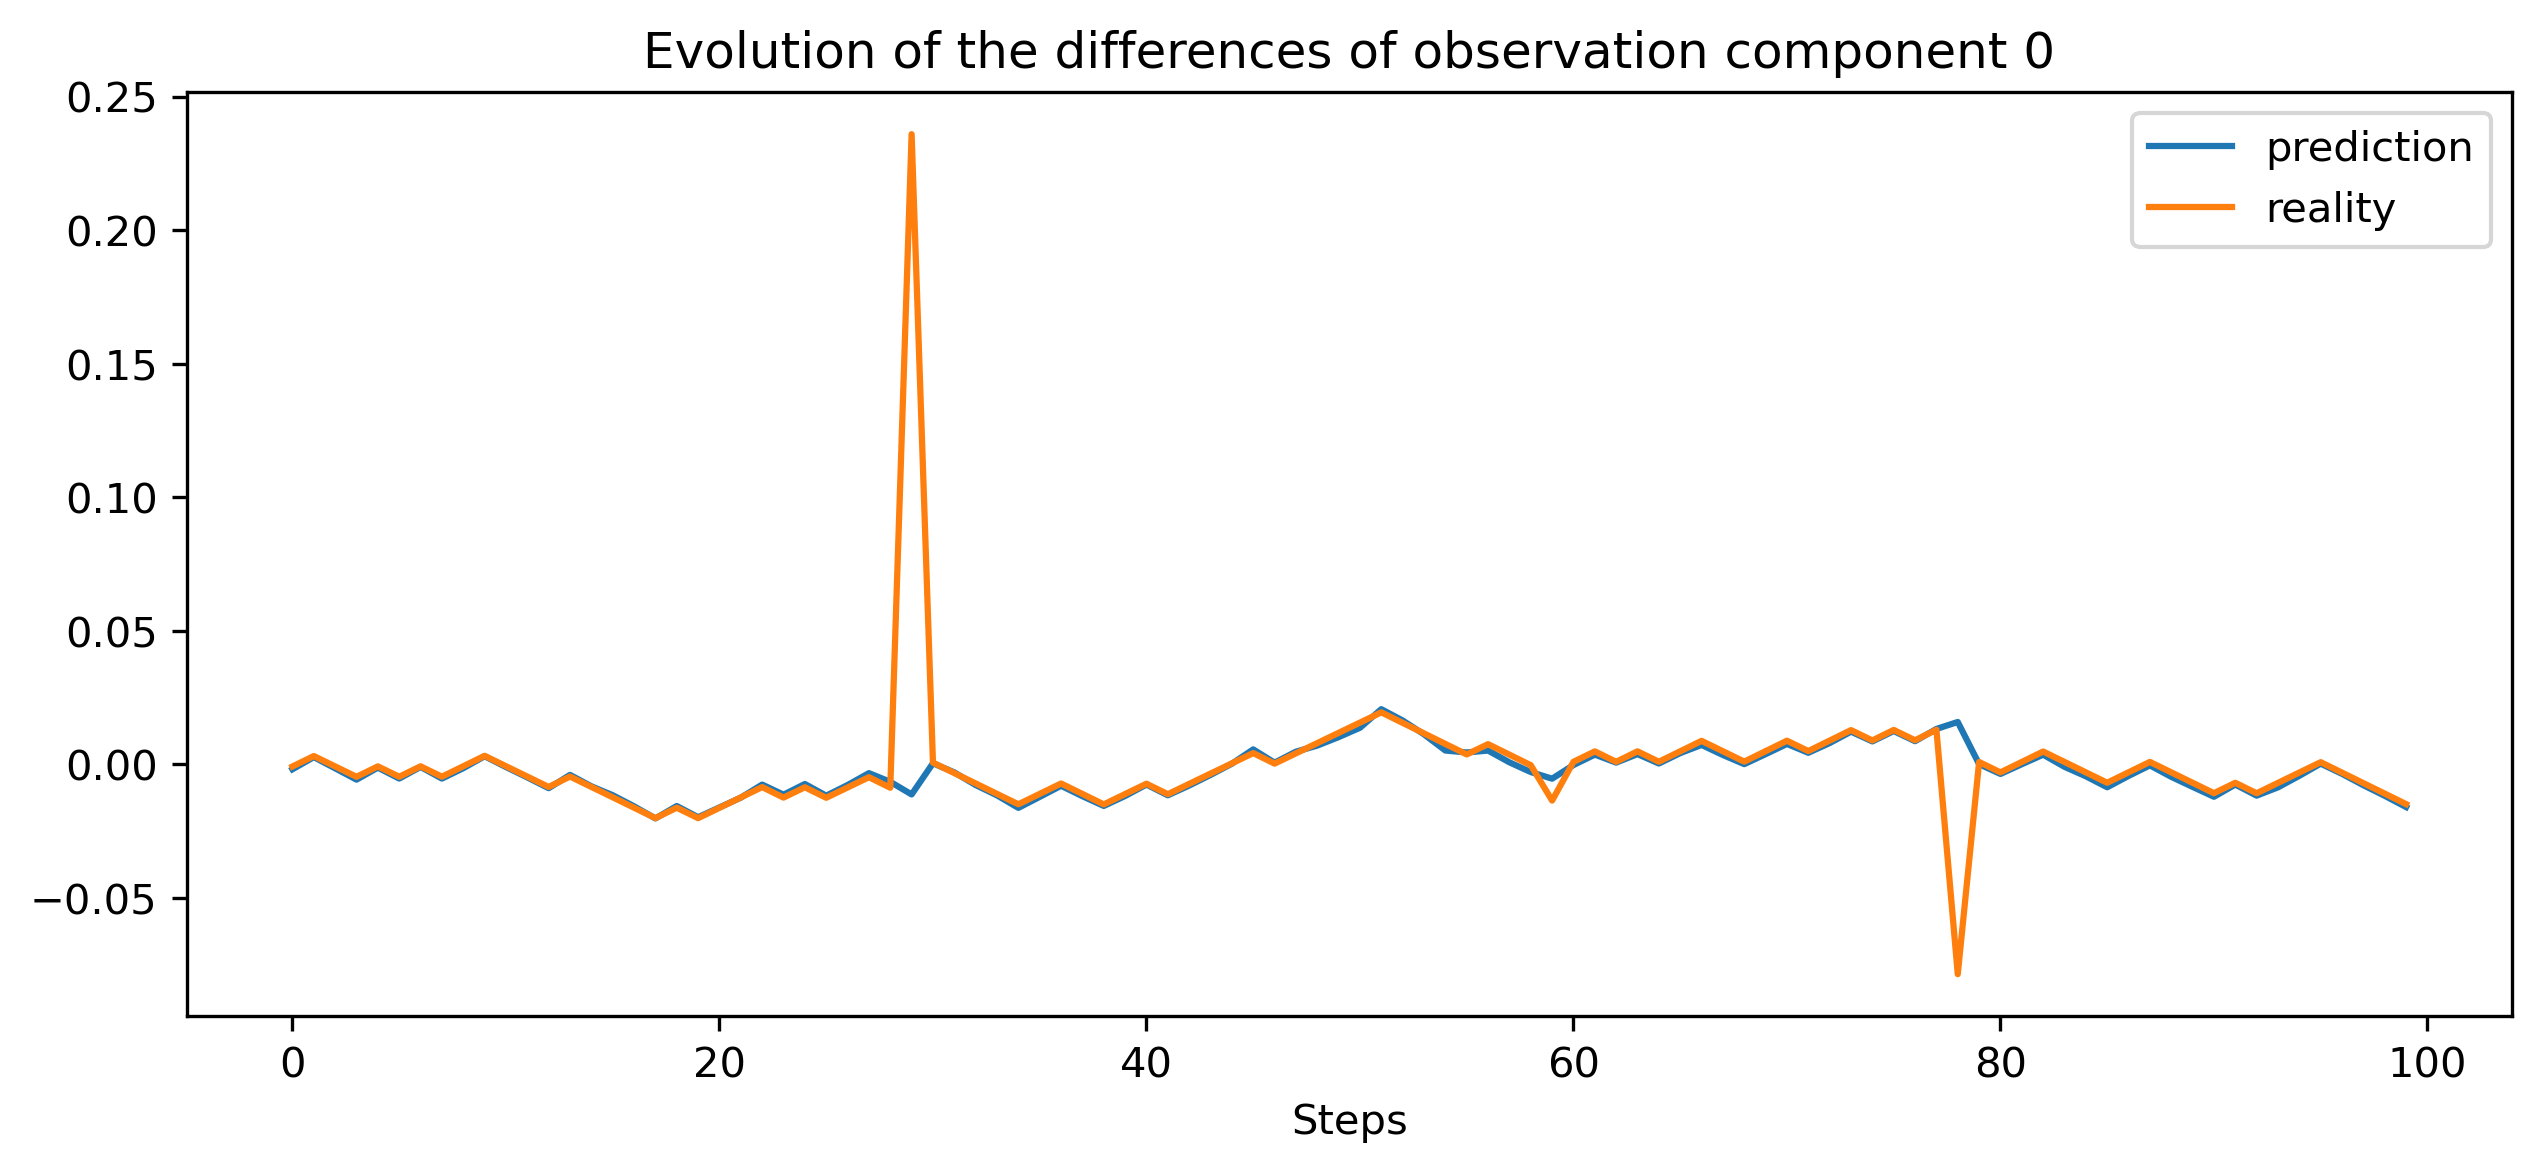

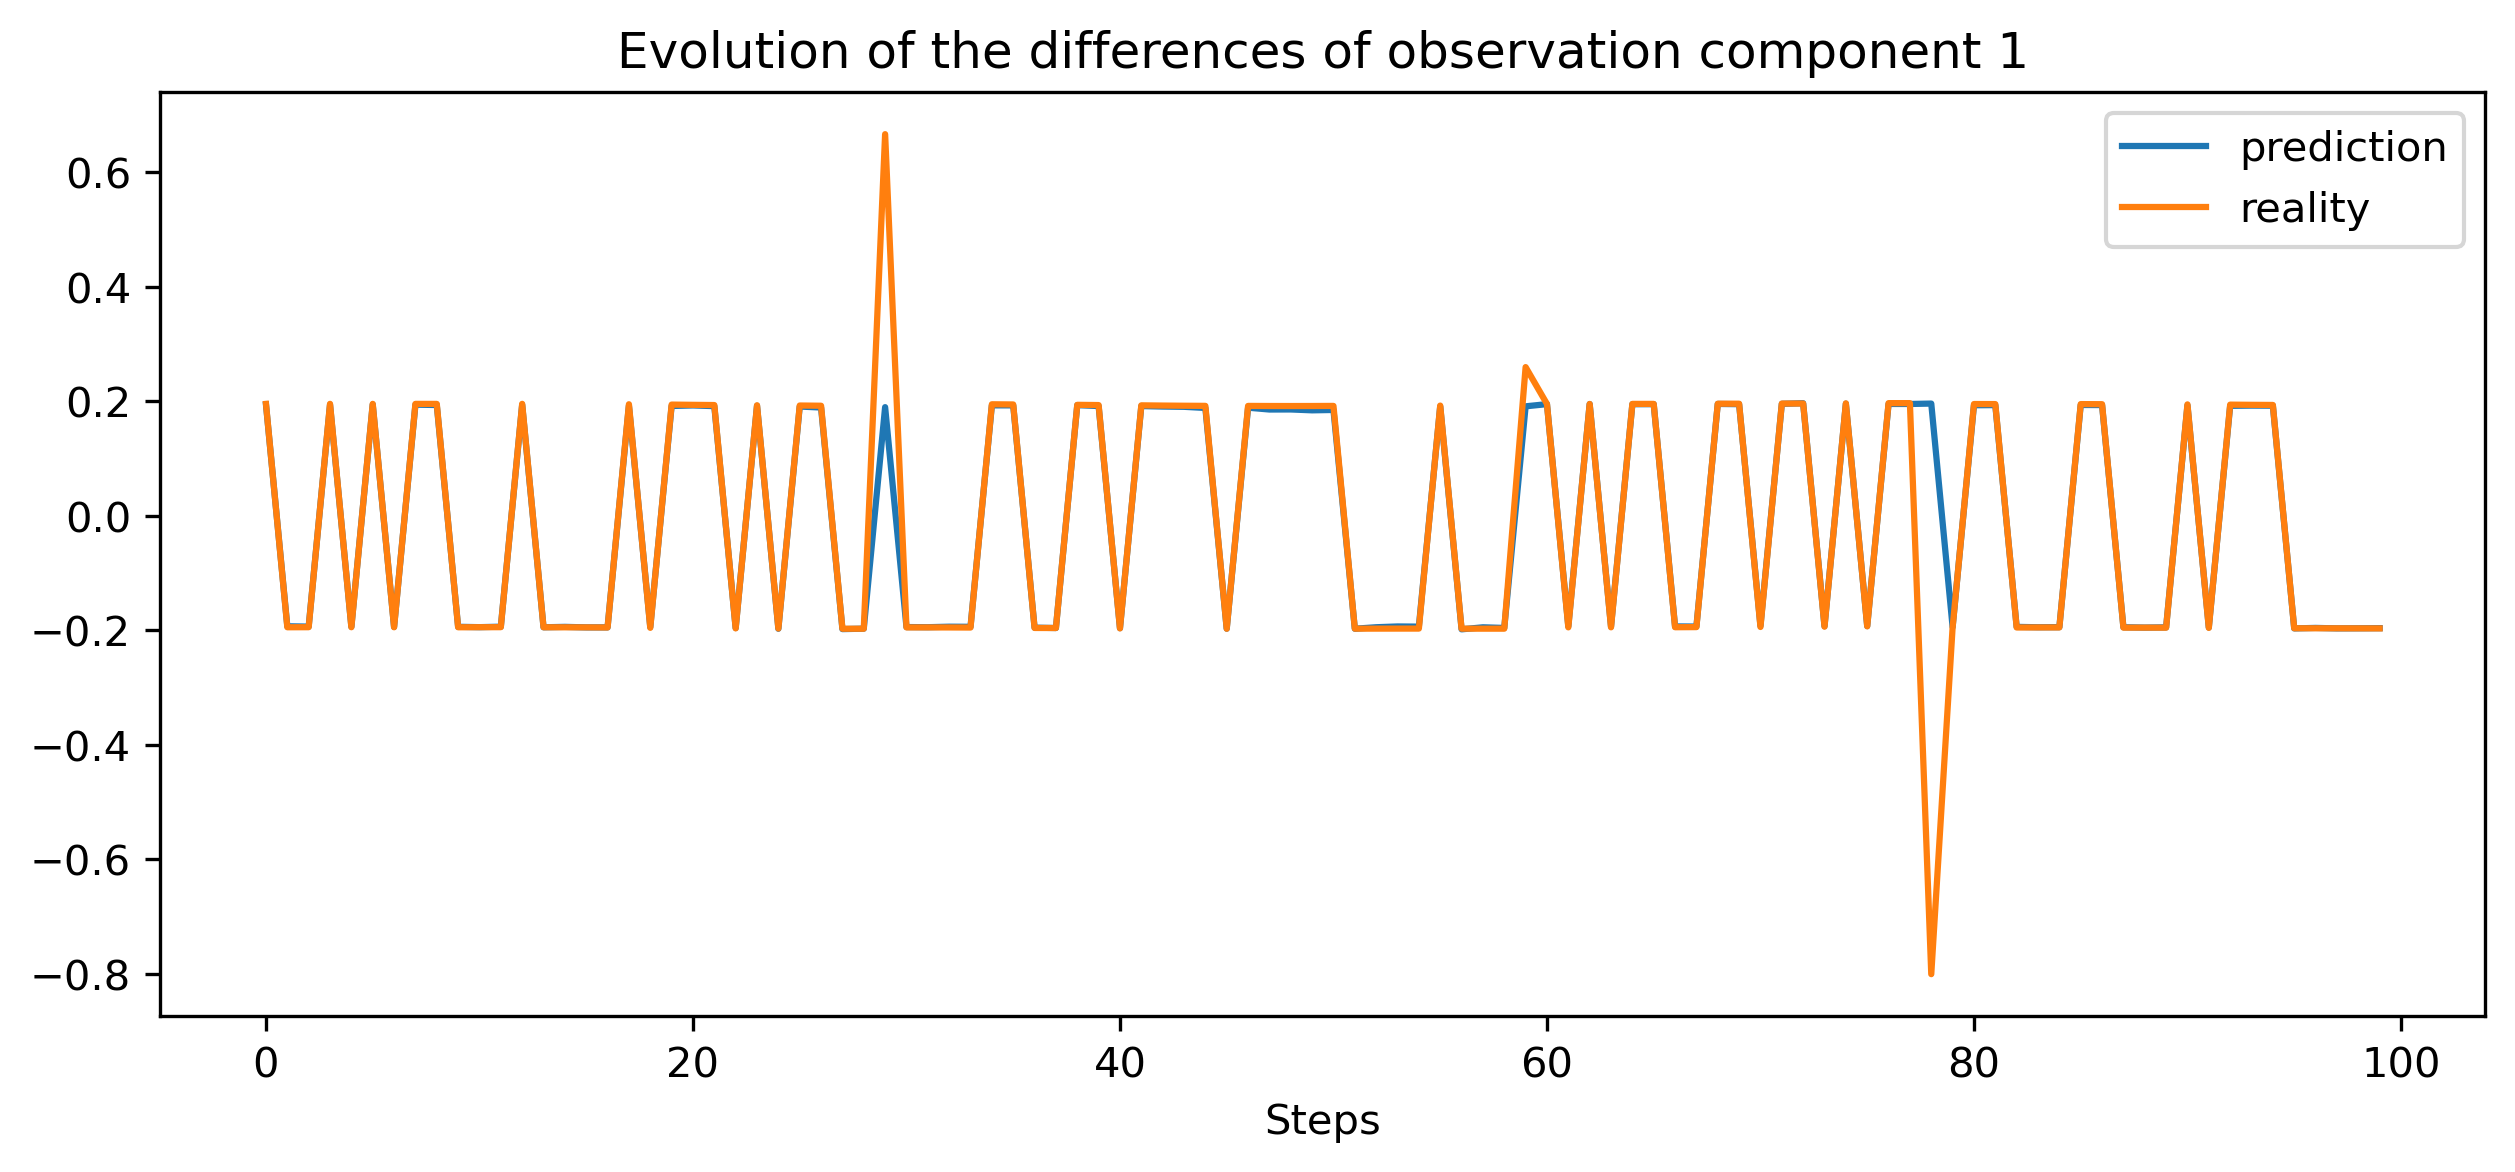

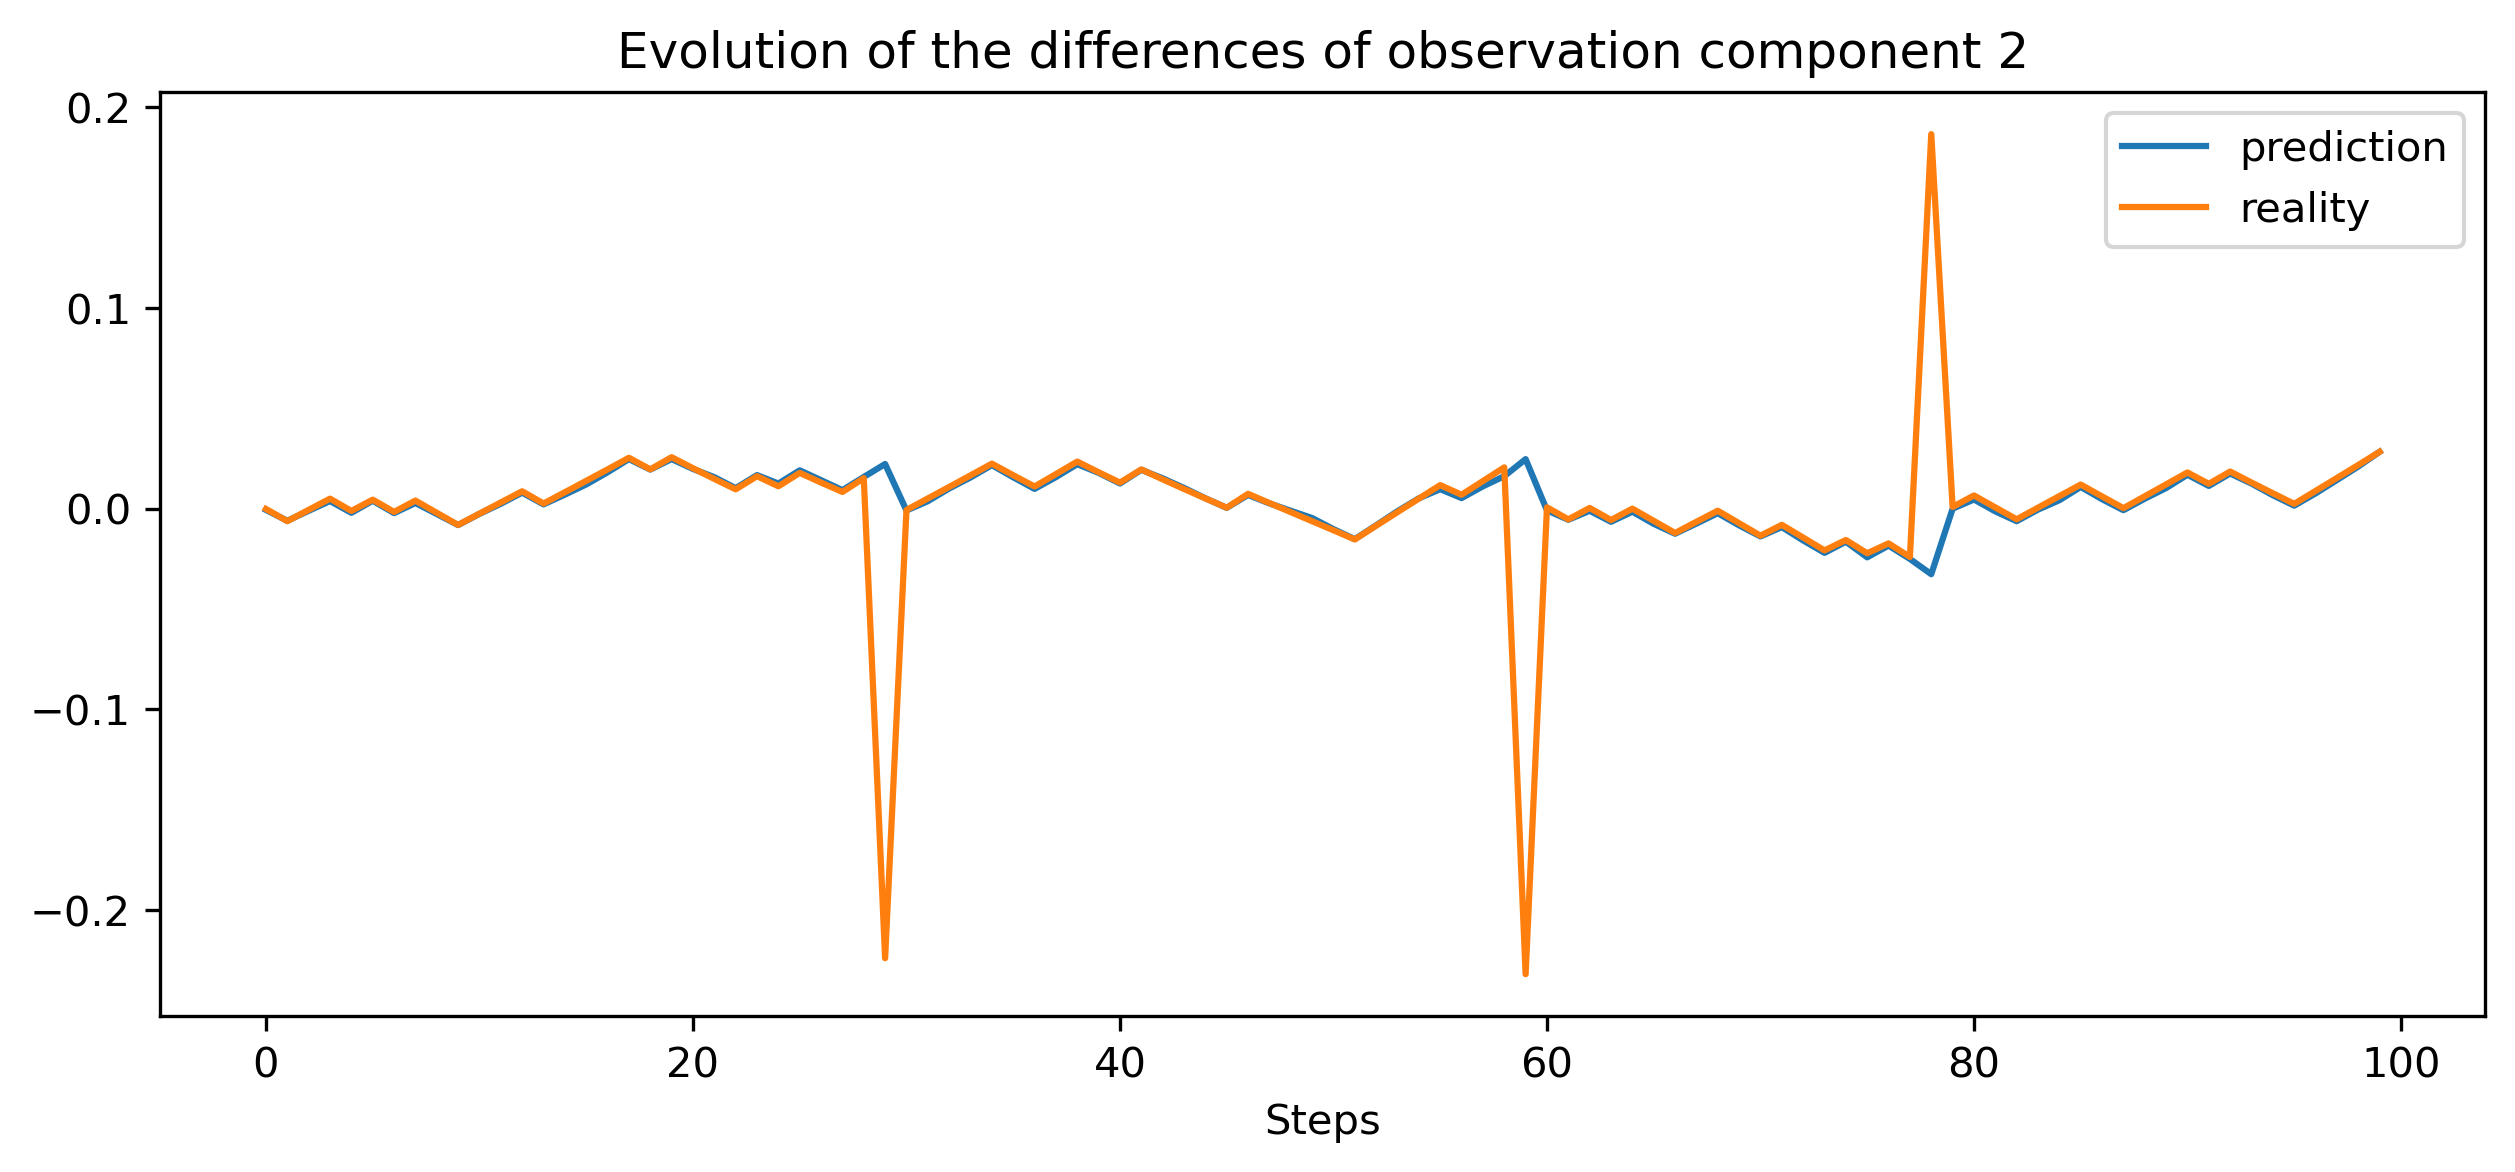

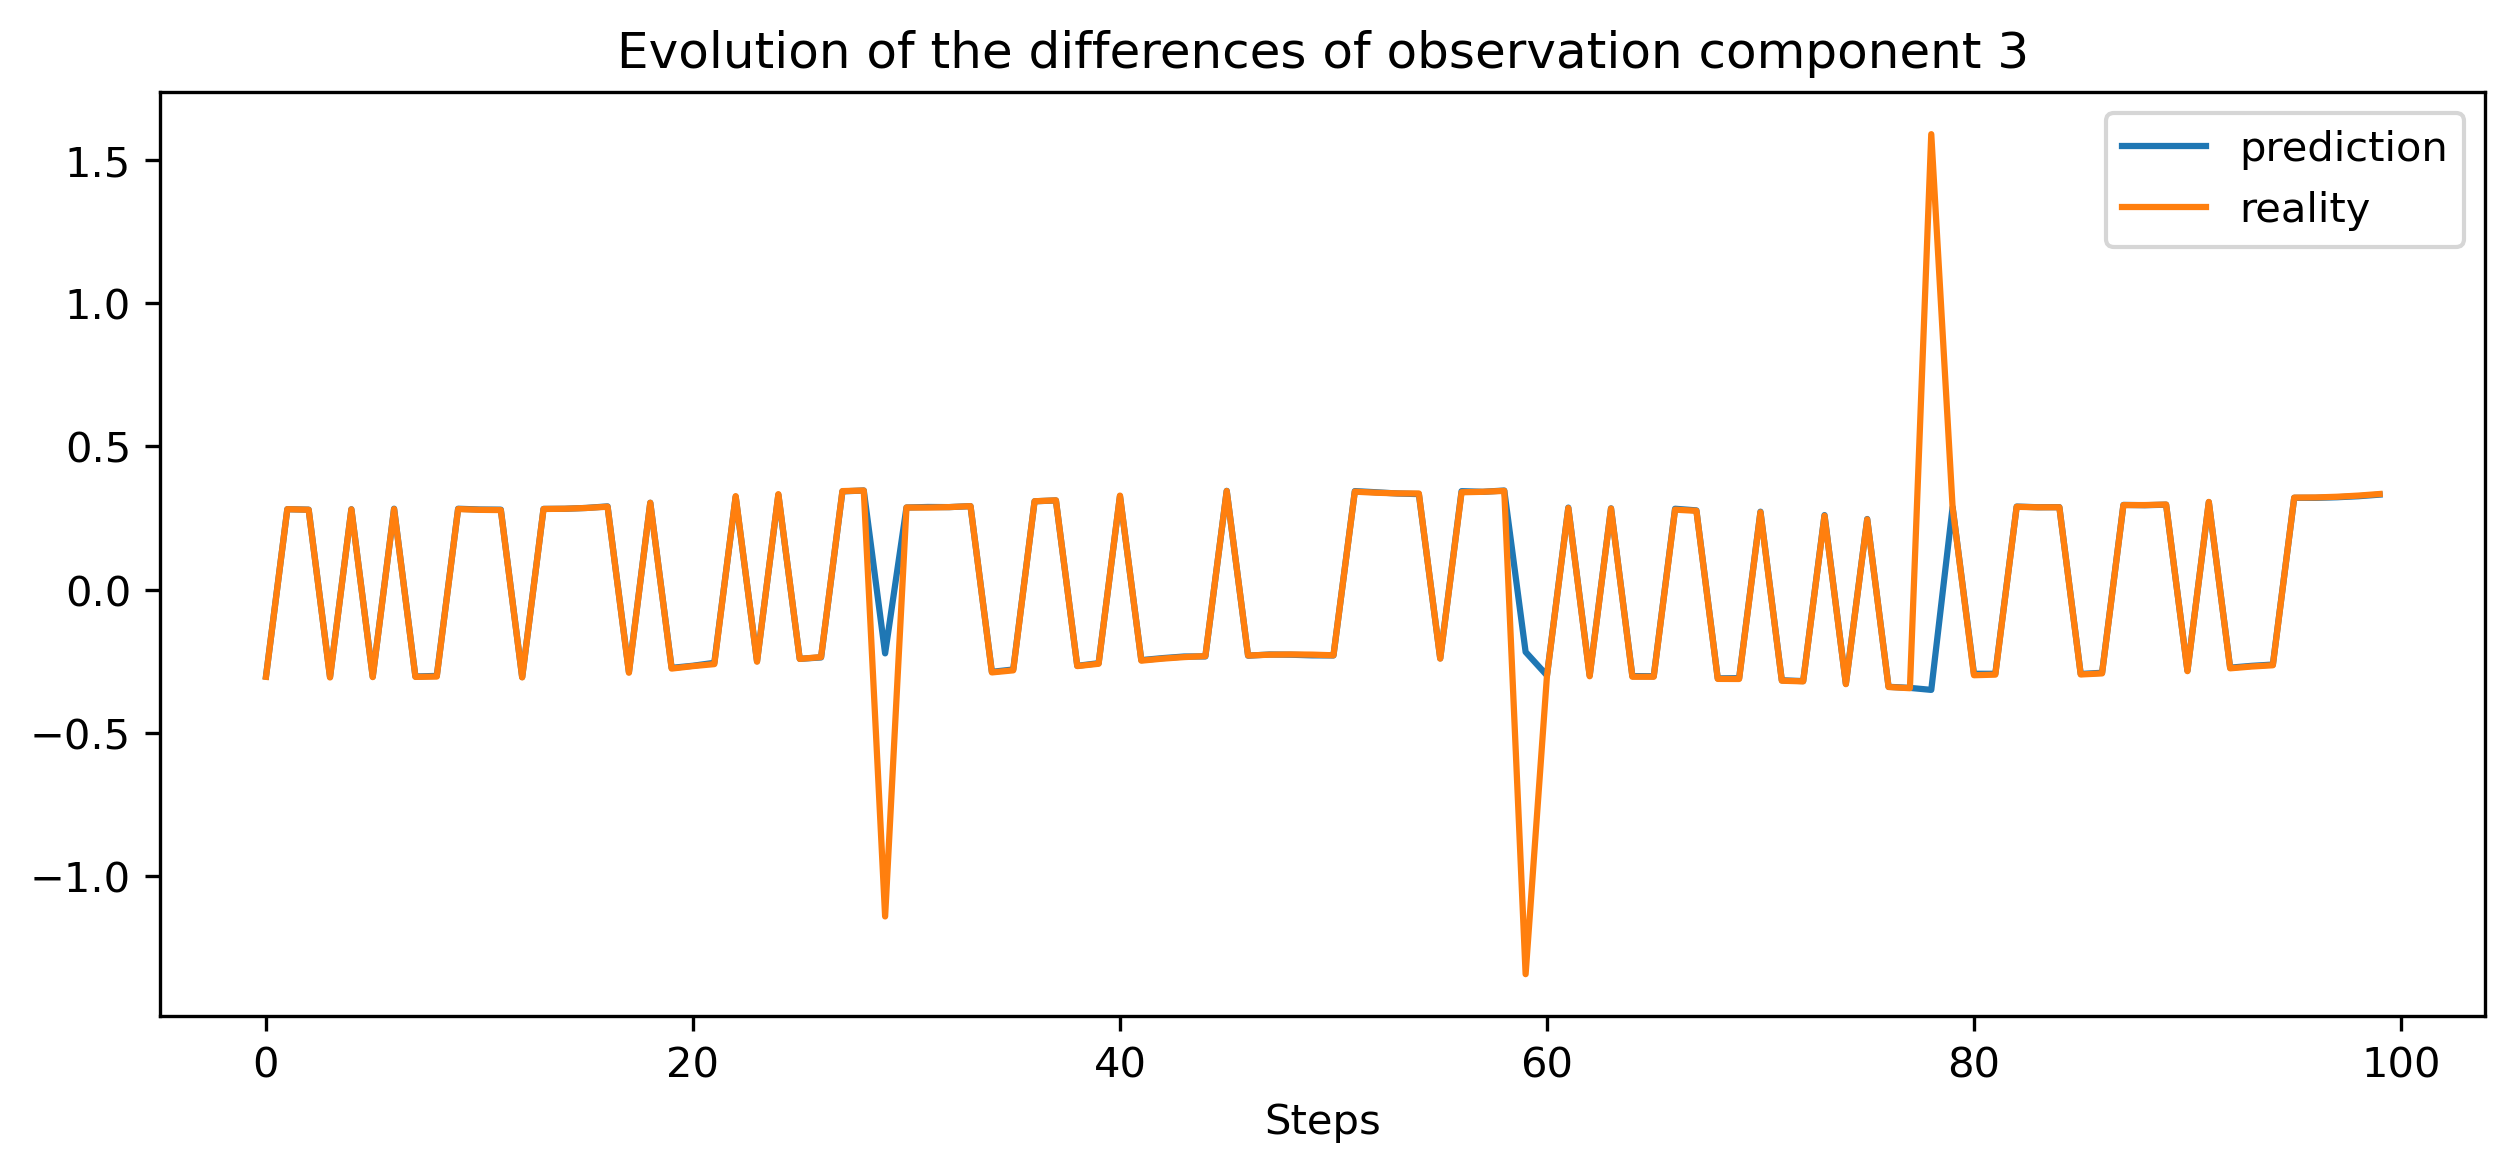

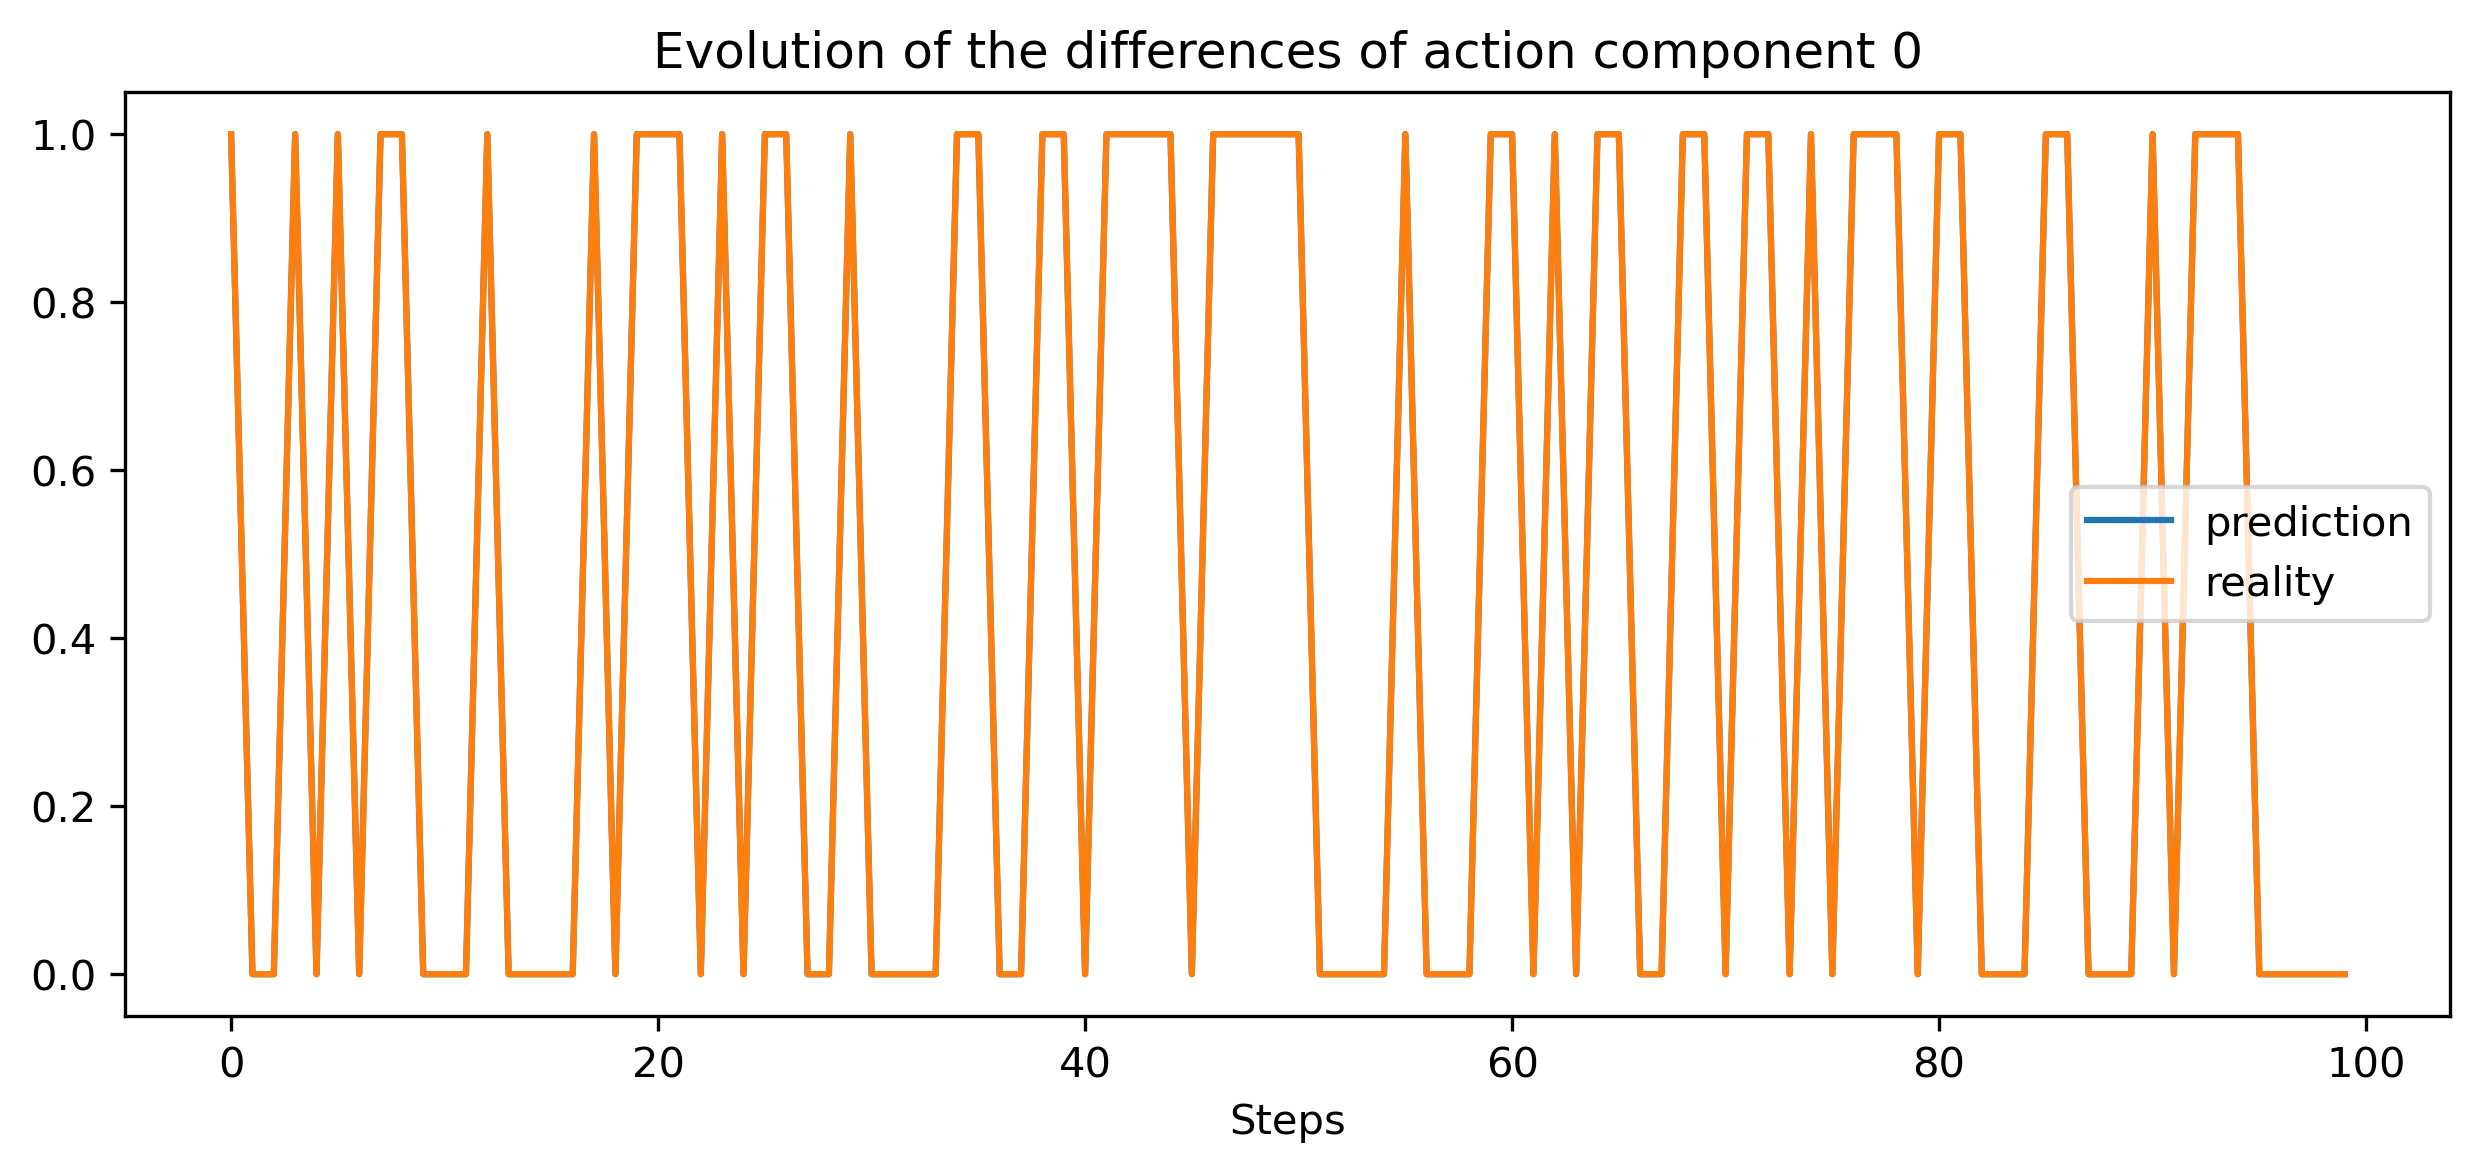

0

In [29]:
model.visualize(env, steps=100)
0

In [ ]:
model = GaussianModel(env, confidence=True, dropout=0.0)
model.fit(env, nb_steps=1000, lr=0.001)
model.save(path / 'saved_models' / 'with_confidence')

Loss: 3271122.8523: 100%|███████████████████████| 25/25 [01:03<00:00,  2.55s/it]


Training complete in 1m 4s
Best val Loss: 8776.063312


Loss: 0.0033:   4%|█▏                            | 1/25 [00:01<00:45,  1.91s/it]

In [ ]:
model.visualize(env, steps=100)
0

In [20]:
£np.array(1)#.reshape( 1)

array(1)

In [21]:
np.all(np.abs([-2, 1, 3]) <= 1.0)

False